<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Используемые инструменты:**

pandas, numpy, matplotlib, statsmodels,sklearn, RandomForestRegressor, CatBoostRegressor, LGBMRegressor.

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    TimeSeriesSplit
)
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

STATE = 42

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df = df.sort_index()
print(df.index.is_monotonic)

True


In [5]:
df = df.resample('1H').sum()

In [6]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


На первом этапе мы загрузили данные и провели их ресемплирование по одному часу. В данных отсутствуют пропуски, все признаки расположены в хронологическом порядке за последние полгода (с 0:00 1 мая 2018 года по 23:50 31 августа 2018).

## Анализ

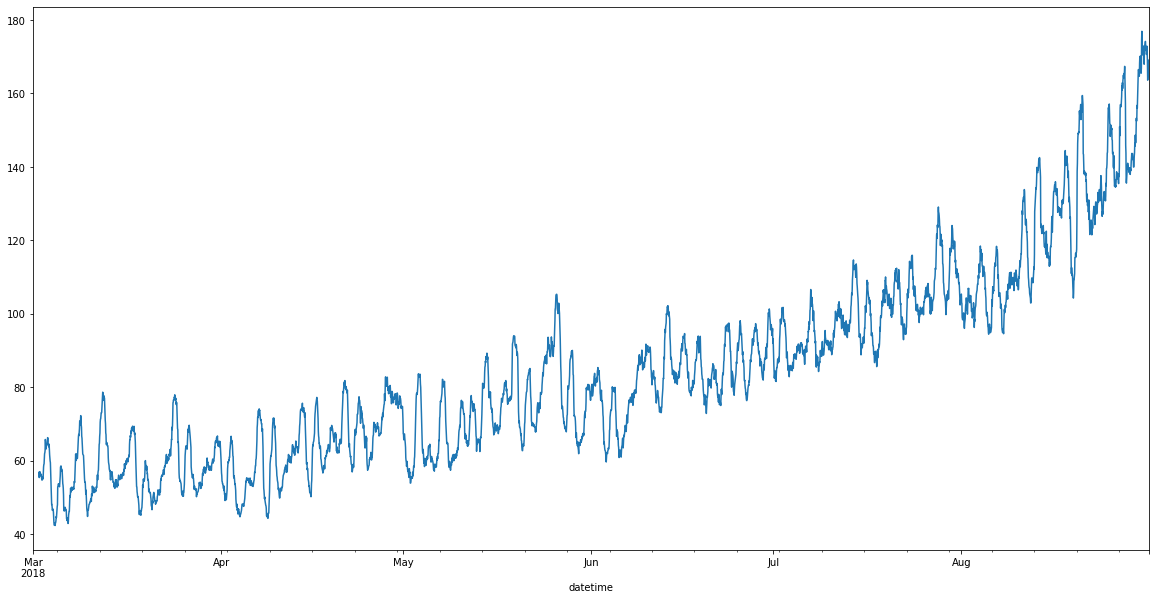

In [7]:
df['num_orders'].rolling(24).mean().plot(figsize=(20, 10))
plt.show()

На этом графике виден плавный рост заказов на протяжении этого полугода, так же, судя по изменению среднего, мы можем сказать, что наш ряд нестационарен. Дополнительно проведём тест Дики-Фуллера.

In [8]:
adf_test = adfuller(df['num_orders'])  
    
print('Критерий ADF: %f' % adf_test[0])    
print('P-значение: %f' % adf_test[1])  
print('Критические значения:')

for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[0] < adf_test[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")  

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


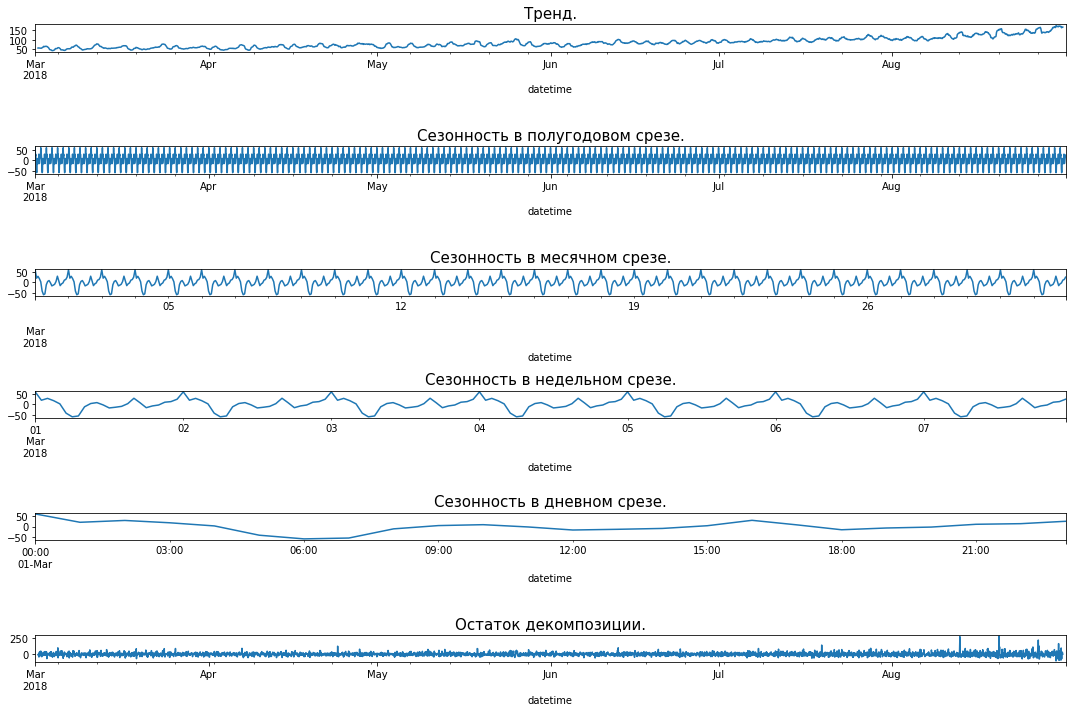

In [9]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(15, 10))
plt.subplot(611)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд.', size=15)
plt.subplot(612)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность в полугодовом срезе.', size=15)
plt.subplot(613)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Сезонность в месячном срезе.', size=15)
plt.subplot(614)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Сезонность в недельном срезе.', size=15)
plt.subplot(615)
decomposed.seasonal['2018-03-01 00:00':'2018-03-01 23:59'].plot(ax=plt.gca())
plt.title('Сезонность в дневном срезе.', size=15)
plt.subplot(616)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции.', size=15)
plt.tight_layout()

На графике тренда видим рост числа заказов такси на протяжении всего времени. Стоит рассмотреть сезонность в дневном срезе отдельно.

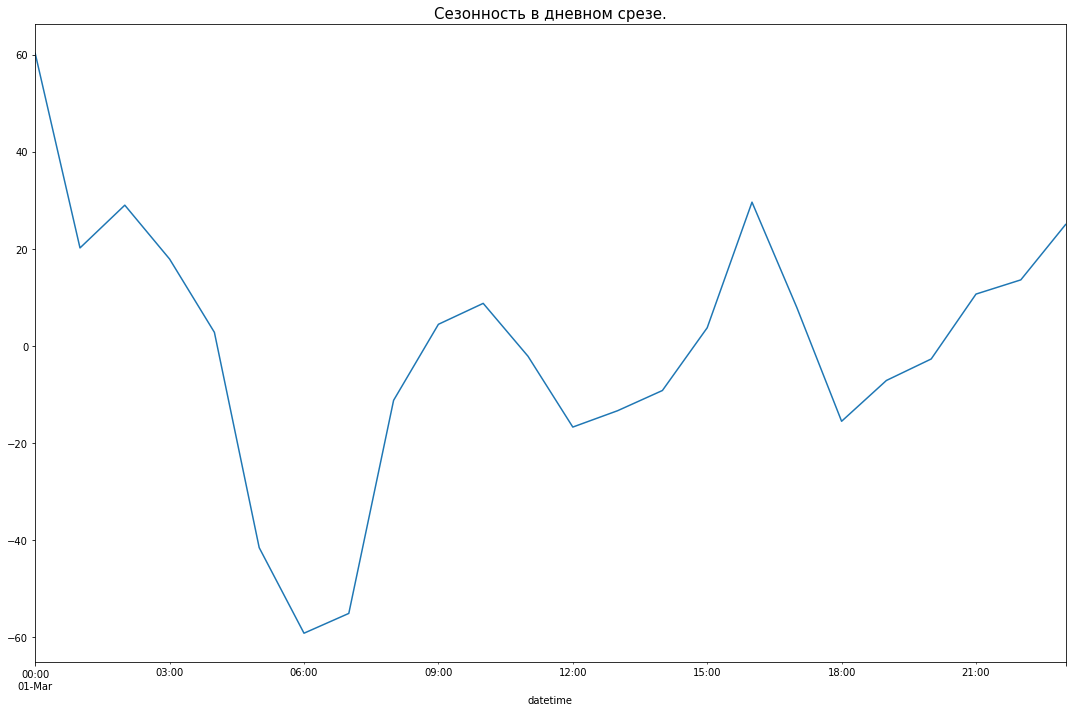

In [10]:
plt.figure(figsize=(15, 10))
decomposed.seasonal['2018-03-01 00:00':'2018-03-01 23:59'].plot(ax=plt.gca())
plt.title('Сезонность в дневном срезе.', size=15)
plt.tight_layout()

На втором этапе мы провели анализ наших данных. С помощью теста определили стационарность временного ряда, не смотря на то, что визально кажется иначе. Выявили тенденцию к увеличению числа заказов за весь период и определили наиболее загруженное время, а именно около 4-5 часов вечера и ночью до 0 часов.

## Обучение

In [11]:
def make_features(data, max_lag, rolling_size):
    data = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    data['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    
    return data
    
make_features(df, 24, 12)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   int64  
 1   hour        4416 non-null   int64  
 2   dayofweek   4416 non-null   int64  
 3   lag_1       4415 non-null   float64
 4   lag_2       4414 non-null   float64
 5   lag_3       4413 non-null   float64
 6   lag_4       4412 non-null   float64
 7   lag_5       4411 non-null   float64
 8   lag_6       4410 non-null   float64
 9   lag_7       4409 non-null   float64
 10  lag_8       4408 non-null   float64
 11  lag_9       4407 non-null   float64
 12  lag_10      4406 non-null   float64
 13  lag_11      4405 non-null   float64
 14  lag_12      4404 non-null   float64
 15  lag_13      4403 non-null   float64
 16  lag_14      4402 non-null   float64
 17  lag_15      4401 non-null   float64
 18  lag_16      4400 non-nul

In [12]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4392 non-null   int64  
 1   hour        4392 non-null   int64  
 2   dayofweek   4392 non-null   int64  
 3   lag_1       4392 non-null   float64
 4   lag_2       4392 non-null   float64
 5   lag_3       4392 non-null   float64
 6   lag_4       4392 non-null   float64
 7   lag_5       4392 non-null   float64
 8   lag_6       4392 non-null   float64
 9   lag_7       4392 non-null   float64
 10  lag_8       4392 non-null   float64
 11  lag_9       4392 non-null   float64
 12  lag_10      4392 non-null   float64
 13  lag_11      4392 non-null   float64
 14  lag_12      4392 non-null   float64
 15  lag_13      4392 non-null   float64
 16  lag_14      4392 non-null   float64
 17  lag_15      4392 non-null   float64
 18  lag_16      4392 non-nul

In [13]:
x = df.drop(['num_orders'], axis=1)
y = df['num_orders']

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.1)

print('Размер обущающей выборки:')
print(x_train.shape)
print(y_train.shape)
print('=' * 100)
print('Размер тестовой выборки:')
print(x_test.shape)
print(y_test.shape)
print('=' * 100)
print('Минимальные и максимальные значения индексов выборок:')
print(x_train.index.min(), x_train.index.max())
print(x_test.index.min(), x_test.index.max())

Размер обущающей выборки:
(3952, 26)
(3952,)
Размер тестовой выборки:
(440, 26)
(440,)
Минимальные и максимальные значения индексов выборок:
2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [14]:
models_rmse = pd.DataFrame(columns = ['Модель', 'RMSE', 'Время обучения'])

In [15]:
%%time

model_rfr = RandomForestRegressor(random_state=STATE)
start_time = time.time()
params = { 'max_depth': range(5, 7),
          'n_estimators': range(20, 60, 10) }
grid_rfr = GridSearchCV(model_rfr, params, cv=TimeSeriesSplit(n_splits=5), 
                        scoring='neg_mean_squared_error', verbose=2)   
grid_rfr.fit(x_train, y_train)
time_rfr = time.time() - start_time
rmse = abs(grid_rfr.best_score_) ** 0.5

print('Лучшая модель RandomForestRegressor c оценкой качества кросс-валидацией:', grid_rfr)
print('Лучшие параметры:', grid_rfr.best_params_)
print('RMSE: {:.3f}'.format(rmse))


models_rmse = models_rmse.append({'Модель':'RandomForestRegressor', 
                                  'RMSE':round(rmse, 3), 
                                  'Время обучения':time_rfr}, ignore_index=True)        

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=30; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=30; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=30; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=30; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=40; total time=   0.2s
[CV] END .......................max_depth=5, n_es

In [16]:
%%time

model_lgbm = LGBMRegressor(random_state=STATE)
start_time = time.time()
params = { 'max_depth': range(5, 7),
          'n_estimators': range(20, 60, 10),
         'learning_rate': [0.4]}
grid_lgbm = GridSearchCV(model_lgbm, params, cv=TimeSeriesSplit(n_splits=5), 
                         scoring='neg_mean_squared_error', verbose=2)   
grid_lgbm.fit(x_train, y_train)
time_lgbm = time.time() - start_time
rmse_lgbm = abs(grid_lgbm.best_score_) ** 0.5

        
print('Лучшая модель LGBMRegressor c оценкой качества кросс-валидацией:', model_lgbm)
print('Лучшие параметры:', grid_lgbm.best_params_)
print('RMSE: {:.3f}'.format(rmse_lgbm))

models_rmse = models_rmse.append({'Модель':'LGBMRegressor', 
                                  'RMSE':round(rmse_lgbm, 3), 
                                  'Время обучения':time_lgbm}, ignore_index=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=20; total time=   4.8s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=20; total time=   0.9s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=20; total time=   4.1s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=20; total time=   9.6s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=20; total time=  10.7s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=30; total time=   4.5s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=30; total time=   7.3s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=30; total time=   7.2s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=30; total time=   4.4s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=30; total time=   3.8s
[CV] END ....learning_rate=0.4, max_depth=5, n_estimators=40; total time=   2.1s
[CV] END ....learning_rate=0.4, max_depth=5, n_es

In [17]:
%%time

model_cbr = CatBoostRegressor(random_state=STATE)
start_time = time.time()
params = { 'max_depth': range(5, 7),
          'n_estimators': range(20, 60, 10),
         'learning_rate': [0.4]}
grid_cbr = GridSearchCV(model_cbr, params, cv=TimeSeriesSplit(n_splits=5), 
                        scoring='neg_mean_squared_error', verbose=2)   
grid_cbr.fit(x_train, y_train)
time_cbr = time.time() - start_time
rmse_cbr = abs(grid_cbr.best_score_) ** 0.5

        
print('Лучшая модель CatBoostRegressor c оценкой качества кросс-валидацией:', model_cbr)
print('Лучшие параметры:', grid_cbr.best_params_)
print('RMSE: {:.3f}'.format(rmse_cbr))

models_rmse = models_rmse.append({'Модель':'CatBoostRegressor', 
                                  'RMSE':round(rmse_cbr, 3), 
                                  'Время обучения':time_cbr}, ignore_index=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 24.6996631	total: 53.3ms	remaining: 1.01s
1:	learn: 21.8408689	total: 55.1ms	remaining: 496ms
2:	learn: 20.3577380	total: 56.8ms	remaining: 322ms
3:	learn: 19.3725841	total: 58.5ms	remaining: 234ms
4:	learn: 18.6550865	total: 60.2ms	remaining: 181ms
5:	learn: 18.0153289	total: 61.8ms	remaining: 144ms
6:	learn: 17.6147520	total: 63.4ms	remaining: 118ms
7:	learn: 17.2314949	total: 65.1ms	remaining: 97.6ms
8:	learn: 16.7137388	total: 66.8ms	remaining: 81.7ms
9:	learn: 16.4332350	total: 68.6ms	remaining: 68.6ms
10:	learn: 16.1157586	total: 70.2ms	remaining: 57.4ms
11:	learn: 15.8008092	total: 71.9ms	remaining: 47.9ms
12:	learn: 15.4536138	total: 73.6ms	remaining: 39.6ms
13:	learn: 15.2128963	total: 75.3ms	remaining: 32.3ms
14:	learn: 15.0181506	total: 77ms	remaining: 25.6ms
15:	learn: 14.6966359	total: 78.8ms	remaining: 19.7ms
16:	learn: 14.4857901	total: 80.5ms	remaining: 14.2ms
17:	learn: 14.3525246	total: 82.2ms	remai

In [18]:
models_rmse

,Модель,RMSE,Время обучения
0,RandomForestRegressor,27.001,15.665025
1,LGBMRegressor,25.806,159.363252
2,CatBoostRegressor,25.559,33.663212


Обучив и сравнив 3 модели с разными гиперпараметрами, мы выбираем модель CatBoostRegressor с гиперпараметрами learning_rate = 0.4, depth = 6, n_estimators = 40. На этой модели используем тестовую выборку.

## Тестирование

In [19]:
rate_cbr_test = 0.4
depth = 6
est = 40

model_cbr_test = CatBoostRegressor(learning_rate=rate_cbr_test, 
                                   depth=depth, 
                                   n_estimators = est, 
                                   random_state=STATE, 
                                   silent=True)

model_cbr_test.fit(x_train, y_train)
predict_test = model_cbr_test.predict(x_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predict_test))
print('RMSE CatBoostRegressor на тестовой выборке: {:.3f}'.format(rmse_test))

RMSE CatBoostRegressor на тестовой выборке: 43.169


In [20]:
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(x_train, y_train)
predict_dummy = model_dummy.predict(x_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, predict_dummy))
print('RMSE DummyRegressor на тестовой выборке: {:.3f}'.format(rmse_dummy))

RMSE DummyRegressor на тестовой выборке: 87.211


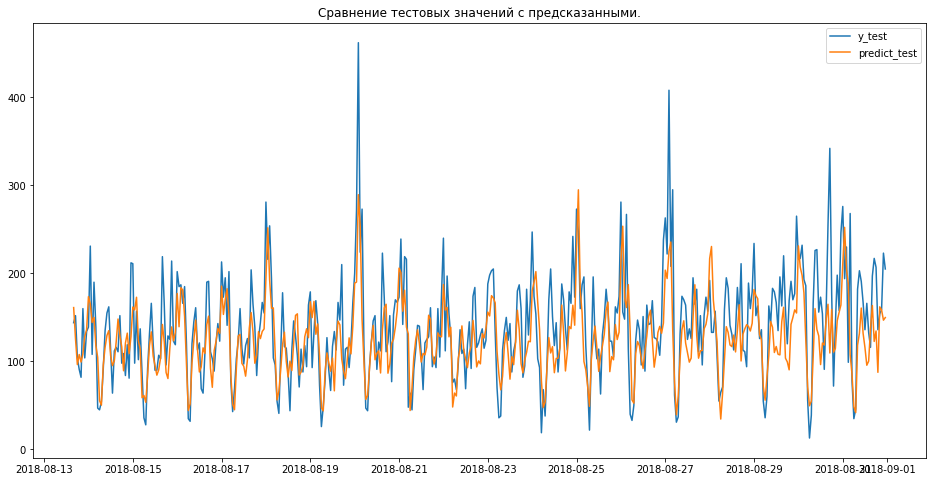

In [21]:
plt.figure(figsize=(16, 8))

plt.plot(y_test, label='y_test')
plt.plot(y_test.index, predict_test, label='predict_test')

plt.title('Сравнение тестовых значений с предсказанными.')
plt.legend()
plt.show()

В нашем распоряжении были данные о заказах такси в аэропорт за последни полгода. Компания «Чётенькое такси» решила, что в период пиковой нагрузки нужно привлекать больше водителей, а для этого нам нужно было построить модель для прогнозирования заказов такси на следующий час.

Мы обучили три модели, а именно RandomForestRegressor, LGBMRegressor и CatBoostRegressor. После обучения и подбора оптимальных гиперпараметров, решили использовать модель CatBoostRegressor на тестовой выборке. Заказчиком было заявлено, что RMSE должно быть не больше 48, наша модель выдала результат в 43.169, что соответствует требованию. Так же была произведена проверка нашей модели на адекватность с помощью константной модели, проверку модель прошла успешно.